In [ ]:
%reset 

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
!pip install wandb

In [2]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt  

We always check that we are running on a GPU

In [9]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We download the dataset when the notebook starts, because it's no longer in the local session

In [10]:
if not os.path.exists('./hotdog_nothotdog'):
  import gdown
  url = 'https://drive.google.com/uc?id=1hwyBl4Fa0IHihun29ahszf1M2cxn9TFk'
  gdown.download(url, './hotdog_nothotdog.zip', quiet=False)
  !unzip ./hotdog_nothotdog.zip > /dev/null

unzip:  cannot find or open ./hotdog_nothotdog.zip, ./hotdog_nothotdog.zip.zip or ./hotdog_nothotdog.zip.ZIP.


Permission denied: https://drive.google.com/uc?id=1hwyBl4Fa0IHihun29ahszf1M2cxn9TFk
Maybe you need to change permission over 'Anyone with the link'?


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use

In [ ]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [ ]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

ValueError: ignored

Let's look at some images from our data 

In [ ]:
images, labels = next(iter(train_loader))
# plt.figure(figsize=(20,10))

# for i in range(21):
#     plt.subplot(5,7,i+1)
#     plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
#     plt.title(['hotdog', 'not hotdog'][labels[i].item()])
#     plt.axis('off')


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

Now create a model and train it!


In [ ]:
def checkpoint(model):
    torch.save(model.state_dict(), wandb.run.dir + wandb.run.name + '.pth')
    wandb.save(wandb.run.dir + wandb.run.name + '.pth')

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 32, 7, padding=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(),

            nn.Conv2d(32, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #nn.Dropout(),
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.ReLU(),
            # nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

             nn.Conv2d(128, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)

                )

        self.fully_connected = nn.Sequential(
                nn.Linear(4*4*256, 1000),
                nn.ReLU(),
                nn.Linear(1000, 200),
                nn.ReLU(),
                nn.Linear(200, 1),
                nn.Sigmoid())
    
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x.view(-1)

In [ ]:
lr = 0.001
epochs = 10

# WANDB 1. Start a new run
wandb.init(project='hotdog', entity='dlincv')

# 2. Save model inputs and hyperparameters
config = wandb.config
config.learning_rate = lr
config.batch_size = batch_size
config.epochs = epochs

# Init network
model = Network()
model.to(device)
wandb.watch(model)

# Loss function
criterion = nn.BCELoss()

#Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10, save_weights=False):
    def loss_fun(output, target):
        return criterion(output.to(torch.float), target.to(torch.float))
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
    test_loss = 0  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            #Compute how many were correctly classified
            train_loss.append(loss.item())
            predicted = (output > 0.5).to(torch.int)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = (output > 0.5).to(torch.int)
            
            test_correct += (target==predicted).sum().cpu().item()
        
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
        
        #wandb.log({"train_acc": out_dict['train_acc'][-1]})
        #wandb.log({"test_acc": out_dict['test_acc'][-1]})
        #wandb.log({"train_loss": out_dict['train_loss'][-1]})
        #wandb.log({"test_loss": out_dict['test_loss'][-1]})
        
        if save_weights and test_loss > out_dict['test_loss'][-1]:
            checkpoint(model)

    return out_dict


Loss train: 0.720	 test: 0.698	 Accuracy train: 52.0%	 test: 48.1%



Loss train: 0.647	 test: 0.575	 Accuracy train: 65.8%	 test: 70.5%



Loss train: 0.534	 test: 0.568	 Accuracy train: 74.1%	 test: 70.7%



Loss train: 0.515	 test: 0.787	 Accuracy train: 76.1%	 test: 63.9%



Loss train: 0.510	 test: 0.580	 Accuracy train: 76.3%	 test: 72.7%



Loss train: 0.477	 test: 0.538	 Accuracy train: 78.0%	 test: 71.2%



Loss train: 0.453	 test: 0.495	 Accuracy train: 78.8%	 test: 75.0%



Loss train: 0.433	 test: 0.584	 Accuracy train: 80.6%	 test: 73.8%



Loss train: 0.428	 test: 0.533	 Accuracy train: 80.5%	 test: 73.3%



Loss train: 0.401	 test: 0.591	 Accuracy train: 82.6%	 test: 75.8%



Text(0, 0.5, 'Accuracy')

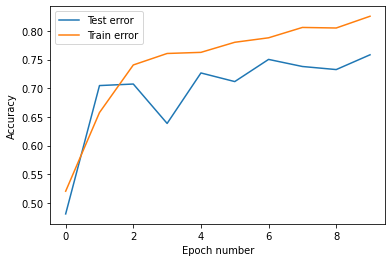

In [ ]:
out_dict = train(model, optimizer, num_epochs=epochs)
plt.plot(out_dict['test_acc'])
plt.plot(out_dict['train_acc'])
plt.legend(('Test error','Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

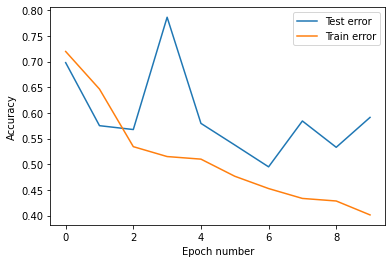

In [ ]:
plt.plot(out_dict['test_loss'])

plt.plot(out_dict['train_loss'])
plt.legend(('Test error','Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features):
        super(ResNetBlock, self).__init__()
        self.res_block = nn.Sequential(
                        nn.Conv2d(n_features, n_features, 3, padding=1),
                        nn.ReLU(),
                        nn.Conv2d(n_features, n_features, 3, padding=1)
        )
    def forward(self, x):
        out = nn.functional.relu(self.res_block(x) + x)
        return out


class ResNet(nn.Module):
    def __init__(self, n_in, n_features, num_res_blocks=3):
        super(ResNet, self).__init__()
        #First conv layers needs to output the desired number of features.
        conv_layers = [nn.Conv2d(n_in, n_features, kernel_size=3, stride=1, padding=1),
                       nn.ReLU()]
        for i in range(num_res_blocks):
            conv_layers.append(ResNetBlock(n_features))
        self.res_blocks = nn.Sequential(*conv_layers)
        self.fc = nn.Sequential(nn.Linear(32*32*n_features, 2048),
                                nn.ReLU(),
                                nn.Linear(2048, 512),
                                nn.ReLU(),
                                nn.Linear(512,10),
                                nn.Softmax(dim=1))
        
    def forward(self, x):
        x = self.res_blocks(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out
